In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import Sequential, Model
from keras.layers import Layer, Input, Dense, Dropout, Flatten, Reshape, Embedding, Concatenate, Dot, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, BinaryCrossentropy
from sklearn.model_selection import train_test_split

In [21]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

In [22]:
from config import Config
from utils.data_loader import DataLoader

In [23]:
train_df = DataLoader().load_train_data()

In [24]:
train_df

,user_id,item_id,rating
0,716,836,4
1,620,422,1
2,547,289,3
3,758,385,4
4,627,197,5
...,...,...,...
79995,336,628,3
79996,749,637,1
79997,758,313,4
79998,380,139,1


In [25]:
val_df = DataLoader().load_val_data()

In [26]:
val_df

,user_id,item_id,rating
0,655,911,2
1,200,88,4
2,763,607,4
3,500,714,2
4,690,163,3
...,...,...,...
19995,932,38,2
19996,154,874,3
19997,527,425,4
19998,464,333,4


In [27]:
x_train, x_test, y_train, y_test = train_df[['user_id', 'item_id']].values, val_df[['user_id', 'item_id']].values, train_df['rating'].values, val_df['rating'].values

In [28]:
x_train.shape

(80000, 2)

In [29]:
class DeepMF(keras.Model):
    
    def __init__(self, latent_dim=5, **kwargs):
        super().__init__(**kwargs)
        self.num_users = Config().vars.NUM_USERS
        self.num_items = Config().vars.NUM_ITEMS
        self.user_embedding = Embedding(self.num_users + 1, latent_dim, name='user_embedding')
        self.user_flatten = Flatten(name='user_flatten')
        self.item_embedding = Embedding(self.num_items + 1, latent_dim, name='item_embedding')
        self.item_flatten = Flatten(name='item_flatten')
        self.dot = Dot(axes=1, name='dot')
    
    def call(self, inputs):
        user_id, item_id = inputs[0], inputs[1]
        user_emb = self.user_embedding(user_id)
        user_emb = self.user_flatten(user_emb)
        item_emb = self.item_embedding(item_id)
        item_emb = self.item_flatten(item_emb)
        rating_vec = self.dot([user_emb, item_emb])
        return rating_vec
    
    def summary(self):
        x = Input(shape=[2])
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [30]:
deepmf = DeepMF()
deepmf.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()]
)

In [31]:
deepmf(tf.Variable([1, 1]))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.1449307e-03],
       [-1.1126152e-03],
       [-5.4452941e-04],
       [-1.5440123e-03],
       [ 5.8165901e-05]], dtype=float32)>

In [32]:
deepmf.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_test[:, 0], x_test[:, 1]], y_test),
    epochs=10,
    batch_size=32,
    validation_freq=3
)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - loss: 13.1077 - mean_squared_error: 13.1077
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 583us/step - loss: 4.1077 - mean_squared_error: 4.1077
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - loss: 1.6096 - mean_squared_error: 1.6096 - val_loss: 1.2561 - val_mean_squared_error: 1.2561
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 1.1414 - mean_squared_error: 1.1414
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step - loss: 0.9910 - mean_squared_error: 0.9910
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - loss: 0.9276 - mean_squared_error: 0.9276 - val_loss: 0.9458 - val_mean_squared_error: 0.9458
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step - loss: 0.9024 - mean_squared_error: 0.9024
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 0.8870 - mean_squared_error: 0.8870
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step - loss: 0.8840 - mean_squared_error: 0

In [33]:
deepmf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (2)               │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (2)               │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (2, 5)            │      4,720 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (2, 5)            │      8,415 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (2, 5)            │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_flatten        │ (2, 5)            │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (2, 1)            │          0 │ user_flatten[0][… │
│                     │                   │            │ item_flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,135 (51.31 KB)

 Trainable params: 13,135 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
deepmf.predict([x_test[:, 0], x_test[:, 1]])

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


array([[1.9774928],
       [4.149642 ],
       [3.9959276],
       ...,
       [3.9464865],
       [4.02154  ],
       [3.5503287]], dtype=float32)

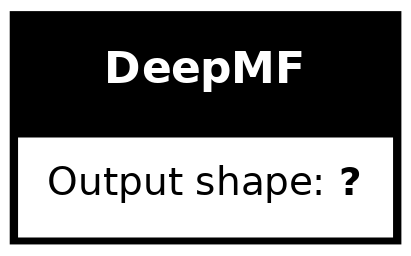

In [37]:
keras.utils.plot_model(deepmf, show_shapes=True)

In [36]:
class GAN():
    
    def __init__(self):
        self.latent_dim = latent_dim
        self.noise_dim = 100
        
        self.optimizer = Adam(0.0002, 0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=BinaryCrossentropy(),
            optimizer=self.optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()

        z = Input(shape=(self.noise_dim,))
        fake_sample = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(fake_sample)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=self.optimizer)
    
    def build_generator(self):
        model = Sequential([
            Dense(10, input_dim=self.noise_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(momentum=0.8),
            Dense(20, input_dim=self.noise_dim),
            LeakyReLU(alpha=0.2),
            Dropout(rate=0.2),
            Dense(self.latent_dim * 2 + 1, activation='linear'),
        ])
        
        model.summary()
        
        noise = Input(shape=(self.noise_dim, ))
        sample = model(noise)
        
        return Model(noise, sample)
    
    def build_discriminator(self):
        model = Sequential([
            Dense(4, input_dim=self.latent_dim * 2 + 1),
            LeakyReLU(alpha=0.2),
            Dense(1, activation='sigmoid')
        ])
        
        model.summary()
        
        sample = Input(shape=(self.latent_dim * 2 + 1, ))
        validity = model(sample)
        
        return Model(sample, validity)
    
    def train(self, dataset, epochs, batch_size=128, sample_interval=50, num_training_samples=100000):
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            idx = np.random.randint(0, num_training_samples, batch_size)
            real_samples = dataset[idx]
            
            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            fake_samples = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(real_samples, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, self.noise_dim))

            g_loss = self.combined.train_on_batch(noise, valid)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                noise = np.random.normal(0, 1, (1, self.noise_dim))